In [39]:
import pdftotext
import pandas as pd
import numpy as np
import re
import os

### Define function for "Cleaning" and "participants list"

In [40]:
def cleaning_text(contents):
    ### Cleaning all the unwanted rows in the transcript
    df = pd.DataFrame(contents)

    # remove the unnessary string
    df[0] = df[0].str.replace('\n','')
    df[0] = df[0].str.replace('Bloomberg Transcript','')
    df[0] = df[0].str.replace('\x0c\n','')
    df[0] = df[0].str.replace('FINAL','')
    df[0] = df[0].str.replace('A - ','')
    df[0] = df[0].str.replace('Q - ','')

    # using re to remove the unnessary string
    def drop_unnessary(x):
        page = re.findall(r'Page \d+ of \d+', x) # 'page ... of ... '
        BIO = re.findall(r'{BIO', x) # '{BIO 18731996 <GO>}'
        Company_Name = re.findall(r'Company N ame:', x) # 'Company N ame: H annover Rueck SE'
        Company_Ticker = re.findall(r'Company Ticker:', x) # 'Company Ticker: H N R1 GR Equity'
        Date = re.findall(r'Date:', x) # Date: 2015-03-10
        if page == [] and BIO == [] and Company_Name == [] and Company_Ticker == [] and Date == []:
            return True
        else:
            return False

    true_false = df[0].apply(lambda x: drop_unnessary(x))
    df = df[true_false]

    # drop the final page declaration
    df = df[df[0] != 'This transcript may not be 100 percent accurate and may contain misspellings and other']
    df = df[df[0] != 'inaccuracies. This transcript is provided "as is", without express or implied warranties of']
    df = df[df[0] != 'any kind. Bloomberg retains all rights to this transcript and provides it solely for your']
    df = df[df[0] != 'personal, non-commercial use. Bloomberg, its suppliers and third-party agents shall']
    df = df[df[0] != 'have no liability for errors in this transcript or for lost profits, losses, or direct, indirect,']
    df = df[df[0] != 'incidental, consequential, special or punitive damages in connection with the']
    df = df[df[0] != 'furnishing, performance or use of such transcript. Neither the information nor any']
    df = df[df[0] != 'opinion expressed in this transcript constitutes a solicitation of the purchase or sale of']
    df = df[df[0] != 'securities or commodities. Any opinion expressed in the transcript does not necessarily']
    # df = df[df[0] != 'reflect the views of Bloomberg LP. ¬© COPYRIGHT 2022, BLOOMBERG LP. All rights']  
    df = df[df[0] != 'reserved. Any reproduction, redistribution or retransmission is expressly prohibited.']
    # ¬© could not be identified, would apply re
    def drop_Bloomberg_mark(x):
        Bloomberg_mark = re.findall(r'reflect the views of Bloomberg LP', x) # 'reflect the views of Bloomberg LP. ¬© COPYRIGHT 2022, BLOOMBERG LP. All rights'
        if Bloomberg_mark == []:
            return True
        else:
            return False

    true_false = df[0].apply(lambda x: drop_Bloomberg_mark(x))
    df = df[true_false]

    # drop the empthy row
    df = df[df[0] != '']
    df = df[df[0] != '']

    return df

def participants_list(df):
    # reset the index to make sure the index is continuous for better processing
    df = df.reset_index(drop=True)

    #  'Company Participants' index
    # df.loc[df[0] == 'Company Participants']
    Participant_start_index = df.index[df.iloc[:,0] == 'Company Participants'].tolist()
    #  'Other Participants' index
    # df.loc[df[0] == 'Other Participants']
    Participant_middle_index = df.index[df.iloc[:,0] == 'Other Participants'].tolist()
    #  'MANAGEMENT DISCUSSION SECTION' index, is the beginning of the management discussion, would stop before this row
    # df.loc[df[0] == 'MANAGEMENT DISCUSSION SECTION']
    Participant_end_index = df.index[df.iloc[:,0] == 'MANAGEMENT DISCUSSION SECTION' ].tolist()
    # try to find the 'MANAGEMENT DISCUSSION SECTION' or 'Presentation' index
    if Participant_end_index == []:
        Participant_end_index = df.index[df.iloc[:,0] == 'Presentation'].tolist()

    print(Participant_start_index, Participant_middle_index, Participant_end_index)

    # make the list of company_paticipants and other_participants
    company_paticipants = df.loc[Participant_start_index[0]+1:Participant_middle_index[0]-1]
    company_paticipants.drop(company_paticipants.index[company_paticipants.iloc[:,0] == ''].tolist(), inplace=True)
    company_paticipants = company_paticipants.values.tolist()

    other_paticipants = df.loc[Participant_middle_index[0]+1:Participant_end_index[0]-1]
    other_paticipants.drop(other_paticipants.index[other_paticipants.iloc[:,0] == ''].tolist(), inplace=True)
    other_paticipants = other_paticipants.values.tolist()

    # print("==========================")
    # print("the company paticipants is: ", company_paticipants)
    # print("==========================")
    # print("the other paticipants is: ", other_paticipants)

    #%%
    # after extract the paticipants, we can drop those information to make the transcript more clear
    df = df.reset_index(drop=True)
    df = df.drop(range(df.index[df.iloc[:,0] == 'Company Participants'].tolist()[0],df.index[df.iloc[:,0].isin(['MANAGEMENT DISCUSSION SECTION','Presentation'])].tolist()[0]+1))

    # drop the first row of the df
    df = df.reset_index(drop=True)
    df = df.iloc[1: , :]


    # reset the index again to make sure the index is continuous for better processing
    df = df.reset_index(drop=True)
    # # save to csv
    # df.to_csv('/Users/timliu/Desktop/output/df.csv')
    return df, company_paticipants, other_paticipants

### Testing on the single company

In [41]:
path = "/Users/timliu/Documents/GitHub/data_collecting/BBG_original_file/European (Re)Insurers/HNR1 GY" #資料夾目錄
save_path = "/Users/timliu/Documents/GitHub/data_collecting/output/HNR1 GY_text"
df = pd.DataFrame()
# create a dataframe with 2500 rows
df_clean_na = pd.DataFrame(np.zeros((2500,1)), columns=['index'])

all_participants = []

files= os.listdir(path) #得到資料夾下的所有檔名稱
for file in files:
    if file.endswith(".pdf"):
        # print(file)
        # Load PDF
        with open(path+"/"+file, "rb") as f:
            pdf = pdftotext.PDF(f)
        # Save all text to a txt file.
        with open(save_path+"/"+file.replace(".pdf", ".txt"), "w") as f:
            f.write("\n\n".join(pdf))
        # open the text file
        with open(save_path+"/"+file.replace(".pdf", ".txt")) as f:
            contents = f.readlines()
            df_clean = cleaning_text(contents)
            # extract all the participants
            df_pure_text,company_paticipants,other_paticipants = participants_list(df_clean)
            all_participants.append(company_paticipants)
            all_participants.append(other_paticipants)
            # using the file name to set as the dataframe's column name
            # df[f"{files.index(file)}"] = df_clean
            df[f"{files[files.index(file)]}"] = df_pure_text
            df_clean_na[f"{files[files.index(file)]}"] = df[f"{files[files.index(file)]}"].dropna(inplace=False).reset_index(drop=True)

# drop the first column of the df
df_clean_na = df_clean_na.iloc[:,1:]
df_clean_na

# save the dataframe
# df_clean_na.to_csv('/Users/timliu/Documents/GitHub/data_collecting/output/test/df_test.csv')


[1] [7] [14]


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[1] [10] [24]
[1] [4] [12]
[1] [4] [17]
[1] [4] [17]
[1] [5] [21]
[1] [6] [13]
[1] [5] [12]
[1] [4] [17]
[1] [4] [13]
[1] [6] [13]
[1] [8] [21]
[1] [4] [16]
[1] [6] [20]
[1] [5] [16]
[1] [6] [18]
[1] [6] [14]
[1] [11] [27]
[1] [5] [19]
[1] [5] [15]
[1] [6] [16]
[1] [4] [17]
[1] [6] [15]
[1] [4] [12]
[1] [5] [12]
[1] [4] [12]
[2] [5] [14]
[1] [4] [13]
[1] [4] [12]
[1] [10] [28]
[1] [6] [14]
[2] [5] [13]
[1] [4] [15]
[1] [4] [17]
[1] [5] [15]
[1] [5] [10]
[1] [9] [17]


,20211104_Hannover_Rueck_SE-_Earnings_Call_2021-11-4_RT000000002967437630.pdf,20191023_Hannover_Rueck_SE-_Shareholder_Mtg_Call_2019-10-23_SD000000002903050937.pdf,20150506_Hannover_Rueck_SE-_Earnings_Call_2015-5-6_FS000000002212304783.pdf,20160804_Hannover_Rueck_SE-_Earnings_Call_2016-8-4_SD000000002853744569.pdf,20171108_Hannover_Rueck_SE-_Earnings_Call_2017-11-8_SD000000002868833083.pdf,20160310_Hannover_Rueck_SE-_Earnings_Call_2016-3-10_FS000000002259507768.pdf,20201104_Hannover_Rueck_SE-_Earnings_Call_2020-11-4_RT000000002931797209.pdf,20210204_Hannover_Rueck_SE-_M-A_Call_2021-2-4_RT000000002949284264.pdf,20180809_Hannover_Rueck_SE-_Earnings_Call_2018-8-9_SD000000002876144587.pdf,20190507_Hannover_Rueck_SE-_Earnings_Call_2019-5-7_DN000000002633135788.pdf,...,20200205_Hannover_Rueck_SE-_M-A_Call_2020-2-5_DN000000002787035776.pdf,20160510_Hannover_Rueck_SE-_Earnings_Call_2016-5-10_FS000000002275763746.pdf,20161020_Hannover_Rueck_SE-_Guidance_Call_2016-10-20_SD000000002902464788.pdf,20210505_Hannover_Rueck_SE-_Earnings_Call_2021-5-5_DN000000002956339792.pdf,20190205_Hannover_Rueck_SE-_Guidance_Call_2019-2-5_SD000000002901846468.pdf,20181108_Hannover_Rueck_SE-_Earnings_Call_2018-11-8_SD000000002879406671.pdf,20150805_Hannover_Rueck_SE-_Earnings_Call_2015-8-5_FS000000002223534191.pdf,20190307_Hannover_Rueck_SE-_Earnings_Call_2019-3-7_DN000000002597819789.pdf,20200506_Hannover_Rueck_SE-_Earnings_Call_2020-5-6_DN000000002833326951.pdf,20211014_Hannover_Rueck_SE-_Shareholder_Mtg_Call_2021-10-14_SD000000002965861183.pdf
0,Operator,Karl Steinle,Operator,Operator,Ulrich Wallin,Karl Steinle,Operator,Operator,Ulrich Wallin,Operator,...,Operator,Operator,Karl Steinle,Operator,Call,Ulrich Wallin,Operator,Operator,Operator,Karl Steinle
1,"Good morning, ladies and gentlemen. I welcome ...",Well. Good morning to all of you. Welcome to H...,"Good morning, ladies and gentlemen, and welcom...","Good morning, ladies and gentlemen. Welcome to...","Good morning, ladies and gentlemen. I'd like t...","Good afternoon everybody here in Frankfurt, an...","Good morning, ladies and gentlemen. I welcome ...","Good morning, ladies and gentlemen. I welcome ...","Yes. Good morning, ladies and gentlemen. I'd l...","Good morning, ladies and gentlemen. I welcome ...",...,Good morning ladies and gentlemen. I welcome y...,"Good morning, ladies and gentlemen, and welcom...","Good morning, to all of you. Welcome to Hannov...","Good morning, ladies and gentlemen. I welcome ...",Operator,"Good morning, ladies and gentlemen. I'd like t...","Good morning, ladies and gentlemen. I welcome ...","Well, good afternoon to everybody here in Lond...","Good morning, ladies and gentlemen. I welcome ...","Hello. Good morning, to the Hannover Re's Inve..."
2,Conference Call on the Q3 2021 Financial Resul...,really delighted that so many of you were able...,Conference Call on Interim Results 1/2015. For...,conference call on interim results (technical ...,presenting the results for the first nine mont...,via the Internet. Welcome to Hannover Re's Ana...,conference call on the Q3 2020 results. For yo...,"Conference Call on 1st January, 2021, Property...",presenting the results for the first half year...,Conference Call on Q1 2019 Results. For your i...,...,"Conference Call on January 1, 2020 Property an...",Conference Call on Interim Results Q1 2016. Fo...,Karl Steinle. And I'm really delighted that so...,Call on the Q1 2021 Results. For your informat...,"Good morning, ladies and gentlemen. I welcome ...",presenting our results for the first nine mont...,Conference Call on Interim Results Q2 2015. Fo...,Internet. Welcome to Hannover Re's Analyst Con...,Conference Call on Q1 2020 Financial Results. ...,on behalf of the entire management team. Again...
3,"being recorded. At this time, I would like to ...","Steinle. And I'm, among other things, responsi...","recorded. At this time, I would like to hand t...","is being recorded. At this time, I would like ...",Roland Vogel.,see that so

### All participants in the single company

In [42]:
# get the value inside the all_participants 
all_participants = [item for sublist in all_participants for item in sublist]
all_participants = [i[0] for i in all_participants]
# print(all_participants)
# %%
# exclude the title of the participants, i.e.'Roland Vogel, CFO' to 'Roland Vogel" by using re
all_participants = [re.sub(r'\,.*', '', participant) for participant in all_participants]
# exclude the 'Property & Casualty Reinsurance'
all_participants = [re.sub(r'Property & Casualty Reinsurance', '', participant) for participant in all_participants]
# exclude the '[0682QB-E Ulrich Wallin]'
all_participants = [re.sub(r'\[0682QB-E Ulrich Wallin\]', '', participant) for participant in all_participants]
# drop duplicated participants
# all_participants = [i[0] for i in all_participants]
# drop the empty string
all_participants = [participant for participant in all_participants if participant != '']
# remove the sapce in the string
all_participants = [participant.strip() for participant in all_participants]
# add the 'Operator' to the list
all_participants.append('Operator')

# drop the duplicated participants
all_participants_copy = all_participants.copy()
all_participants = []
# drop the duplicated participants
for i in all_participants_copy: 
    if i not in all_participants: 
        all_participants.append(i) 

all_participants = sorted(all_participants)

In [43]:
all_participants

['Anasuya Iyer',
 'Andreas Maerkert',
 'Andreas Markert',
 'Andreas MÃ¤rkert',
 'Andreas Schaefer',
 'Andreas Schafer',
 'Andreas SchÃ¤fer',
 'Andreas Schäfer',
 'Andrew Broadfield',
 'Andrew J. Ritchie',
 'Andrew James Ritchie',
 'Andrew Richie',
 'Andrew Ritchie',
 'Andy D. Broadfield',
 'Ashik Musaddi',
 'Ben Cohen',
 'Bill Hawkins',
 'Claude Chevre',
 'Claude Jacques Chevre',
 'Claude Jacques ChÃ¨vre',
 'Clemens Jungsthofel',
 'Daniel Bischof',
 'Darius Satkauskas',
 'Dieter Hein',
 'Eberhard Mueller',
 'Edward Morris',
 'Emanuele Musio',
 'Farooq Hanif',
 'Frank Kopfinger',
 'Guilhem Horvath',
 'Henry Heathfield',
 'Iain Pearce',
 'In-Yong Hwang',
 'Ivan Bokhmat',
 'James Austin Shuck',
 'James R Oram',
 'James Shuck',
 'Janet Van den Berg',
 'Jean-Jacques Hencho',
 'Jean-Jacques Henchoz',
 'Jochen Schmitt',
 'Jonathan Denham',
 'Jonathan Peter Phillip Urwin',
 'Jonathan Urwin',
 'Jonny Urwin',
 'Juergen Graeber',
 'JÃ¼rgen GrÃ¤ber',
 'Kamran Hossain',
 'Karl Steinle',
 'Klaus Mil

In [44]:
new_df = pd.DataFrame()
# identify the len before NaN of each column
for column in df_clean_na.columns:
    # end_index = len(df_clean_na[column])-df_clean_na.isnull().sum(axis = 0)[column]-1
    # # 這邊要注意775是NaN 所以774還是有值的
    # identify all the rows in df with all_participants in it
    both_participants_row_index = df_clean_na[df_clean_na[column].isin(all_participants)].index.tolist()
    # # append the end_index to the end of both_participants_row_index
    # both_participants_row_index.append(end_index)
    # apply the both_participants_row_index to the df_clean_na['participants']
    new_df[column] = df_clean_na[column]
    new_df[f"participants_{column}"] = df_clean_na[column].apply(lambda x: x if x in all_participants else np.nan)
    # fill the NaN with the value of the previous row
    new_df[f"participants_{column}"] = new_df[f"participants_{column}"].fillna(method='ffill')
    # # exclude the row if pure_df[column]==pure_df[f"participants_{column}"]
    # pure_df = pure_df[pure_df[column] != pure_df[f"participants_{column}"]]

## Split with the file and add the date

In [45]:
pure_df = pd.DataFrame()
# identify the len before NaN of each column
for column in df_clean_na.columns:
    # exclude the row if pure_df[column]==pure_df[f"participants_{column}"]
    pure_df = new_df[new_df[column] != new_df[f"participants_{column}"]]
# drop the column if the column start with participants
pure_df = pure_df.drop(pure_df.columns[pure_df.columns.str.startswith('participants_')], axis=1).T

# append the text of each roll into one string by using s.str.cat(sep='. ')
pure_df = pure_df.apply(lambda x: x.str.cat(sep='. '), axis=1)
# change the pure_df to dataframe
pure_df = pd.DataFrame(pure_df)
# rename the column
pure_df.columns = ['meeting_text']
# extract the index as column from the text
pure_df['file_name'] = pure_df.index
# extract the date from the index column
pure_df['date'] = pure_df['file_name'].apply(lambda x: x.split('_')[0])
# change the date column to datetime
pure_df['date'] = pd.to_datetime(pure_df['date'])
# reset the index
pure_df = pure_df.reset_index(drop=True)
pure_df

#save the dataframe
# pure_df.to_csv('/Users/timliu/Documents/GitHub/data_collecting/output/test/pure_df.csv')

,meeting_text,file_name,date
0,"Good morning, ladies and gentlemen. I welcome ...",20211104_Hannover_Rueck_SE-_Earnings_Call_2021...,2021-11-04
1,Well. Good morning to all of you. Welcome to H...,20191023_Hannover_Rueck_SE-_Shareholder_Mtg_Ca...,2019-10-23
2,"Good morning, ladies and gentlemen, and welcom...",20150506_Hannover_Rueck_SE-_Earnings_Call_2015...,2015-05-06
3,"Good morning, ladies and gentlemen. Welcome to...",20160804_Hannover_Rueck_SE-_Earnings_Call_2016...,2016-08-04
4,"Good morning, ladies and gentlemen. I'd like t...",20171108_Hannover_Rueck_SE-_Earnings_Call_2017...,2017-11-08
5,"Good afternoon everybody here in Frankfurt, an...",20160310_Hannover_Rueck_SE-_Earnings_Call_2016...,2016-03-10
6,"Good morning, ladies and gentlemen. I welcome ...",20201104_Hannover_Rueck_SE-_Earnings_Call_2020...,2020-11-04
7,"Good morning, ladies and gentlemen. I welcome ...",20210204_Hannover_Rueck_SE-_M-A_Call_2021-2-4_...,2021-02-04
8,"Yes. Good morning, ladies and gentlemen. I'd l...",20180809_Hannover_Rueck_SE-_Earnings_Call_2018...,2018-08-09
9,"Good morning, ladies and gentlemen. I welcome ...",20190507_Hannover_Rueck_SE-_Earnings_Call_2019...,2019-05-07


## Testing on the single company

### splitting with paragraph

In [46]:
paragrapg_df = new_df.iloc[:,:2]
# drop the NaN
paragrapg_df = paragrapg_df.dropna(inplace=False)
#rename the second column to 'participants', first column to 'text'
paragrapg_df.columns = ['text', 'participants']
# if the text is empty, drop it
paragrapg_df = paragrapg_df[paragrapg_df['text'] != '']
# reset the index
paragrapg_df = paragrapg_df.reset_index(drop=True)
# if 'text' == 'participants', get the index of the row
paragrapg_index = paragrapg_df[paragrapg_df['text'] == paragrapg_df['participants']].index.tolist()

# +1 for every value in paragrapg_index
start_paragrapg_index = []
for i in range(len(paragrapg_index)):
    start_paragrapg_index.append(paragrapg_index[i]+1)
# disregard the last value in the list
start_paragrapg_index = start_paragrapg_index[:-1]
print(len(start_paragrapg_index))
# -1 for every value in paragrapg_index
end_paragrapg_index = []
for i in range(len(paragrapg_index)):
    end_paragrapg_index.append(paragrapg_index[i])
# disregard the first value in the list
end_paragrapg_index = end_paragrapg_index[1:]
print(len(end_paragrapg_index))

# extracct the text of the paragrapg_df between end_paragrapg_index and start_paragrapg_index
paragraph_split_df = pd.DataFrame()
for i in range(len(start_paragrapg_index)):
    paragraph = paragrapg_df.iloc[start_paragrapg_index[i]:end_paragrapg_index[i]]
    # merge the paragraph to one cell 
    paragraph_text = paragraph.apply(''.join).to_frame().T
    # appemd the paragraph_text['text'].iloc[:,0] to the paragraph_split_df
    paragraph_split_df = paragraph_split_df.append(paragraph_text, ignore_index=True)

# look up for paragrapg_df['participants'] from the start_paragrapg_index
participants = paragrapg_df.iloc[start_paragrapg_index,1].to_frame()
# reset the index
participants = participants.reset_index(drop=True)

paragraph_split_df['participants'] = participants
paragraph_split_df

65
65


,text,participants
0,"Good morning, ladies and gentlemen. I welcome ...",Operator
1,"Well, good morning, everyone and welcome to ou...",Jean-Jacques Henchoz
2,"Thank you very much, Clemens. On the next slid...",Jean-Jacques Henchoz
3,"(Question And Answer)Ladies and gentlemen, we ...",Operator
4,"Hi. Good morning, everyone. Could I just dig i...",Andrew Ritchie
...,...,...
60,Yes. Two quick questions. The first one would ...,Thomas Fossard
61,"And on the NatCat, so as Jean-Jacques explaine...",Klaus Miller
62,Thank you. Thank you.,Thomas Fossard
63,And there are no further questions at this poi...,Operator


### splitting with participants (a bit useless)

In [47]:
# take two of the first column as test df
single_meeting_df = new_df.iloc[:,:2]
# rename the second column to 'participants'
single_meeting_df.columns = ['text', 'participants']
# drop the NaN
single_meeting_df = single_meeting_df.dropna(inplace=False)
# if the text is empty, drop it
single_meeting_df = single_meeting_df[single_meeting_df['text'] != '']
# drop if 'text' == 'participants'
single_meeting_df = single_meeting_df[single_meeting_df['text'] != single_meeting_df['participants']]

list_participants = [] 
list_participants.append(single_meeting_df['participants'].unique().tolist())
list_participants = list_participants[0]

# create participants_split_df with column of 'participants' and 'text'
participants_split_df = pd.DataFrame()

for i in range(len(list_participants)):
    processing_df = single_meeting_df.copy()
    # 萃取出所有的participantsj中Operator說的話
    processing_df['participants'] = processing_df['participants'].apply(lambda x: x if x == f"{list_participants[i]}" else np.nan)
    # drop the NaN
    processing_df = processing_df.dropna(inplace=False)
    processing_df = processing_df.apply(''.join).to_frame().T
    processing_df['participants'] =  f"{list_participants[i]}"
    participants_split_df = participants_split_df.append(processing_df, ignore_index=True)


participants_split_df

,text,participants
0,"Good morning, ladies and gentlemen. I welcome ...",Operator
1,"Well, good morning, everyone and welcome to ou...",Jean-Jacques Henchoz
2,"Hi. Good morning, everyone. Could I just dig i...",Andrew Ritchie
3,"Yes. With regard to the major loss budget, hap...",Sven Althoff
4,"Okay. Now, I'm happy to take the question on t...",Klaus Miller
5,"Hey, good morning. Thank you very much. So, a ...",Vinit Malhotra
6,"On the cash flow, nothing really significant. ...",Unidentified Speaker
7,"Hi, morning, everyone. Just a quick follow-up ...",William Hardcastle
8,Yes. Good morning. Couple of questions. The fi...,Thomas Fossard
9,Hi. Thanks for taking my questions. The first ...,Iain Pearce


### splitting with sentences 
and will have the participants_split_df split the text by '.'

In [48]:
# write a function to split the text by '.' in paragraph_split_df
p_to_s_split_df = paragraph_split_df.copy()

def split_text(text):
    text = text.split(". ")
    return text
# apply the function to the paragraph_split_df
p_to_s_split_df['text'] = p_to_s_split_df['text'].apply(lambda x: split_text(x))
p_to_s_split_df

,text,participants
0,"[Good morning, ladies and gentlemen, I welcome...",Operator
1,"[Well, good morning, everyone and welcome to o...",Jean-Jacques Henchoz
2,"[Thank you very much, Clemens, On the next sli...",Jean-Jacques Henchoz
3,"[(Question And Answer)Ladies and gentlemen, we...",Operator
4,"[Hi, Good morning, everyone, Could I just dig ...",Andrew Ritchie
...,...,...
60,"[Yes, Two quick questions, The first one would...",Thomas Fossard
61,"[And on the NatCat, so as Jean-Jacques explain...",Klaus Miller
62,"[Thank you, Thank you.]",Thomas Fossard
63,[And there are no further questions at this po...,Operator


In [49]:
sentence_split_df = pd.DataFrame()
for i in range(len(p_to_s_split_df)):
    sentence_list = p_to_s_split_df['text'].iloc[i]
    sentence_split_single_df = pd.DataFrame (sentence_list, columns = ['sentence'])
    sentence_split_single_df['participants'] = p_to_s_split_df['participants'].iloc[i]
    sentence_split_single_df['paragraph'] = i
    sentence_split_df = sentence_split_df.append(sentence_split_single_df, ignore_index=True)
# drop if the 'sentence' is empty
sentence_split_df = sentence_split_df.dropna(inplace=False)

sentence_split_df

# safe the dataframe with the path
path = '/Users/timliu/Documents/GitHub/data_collecting/df_for_NLP/sentence_split_df.csv'
sentence_split_df.to_csv(path)
sentence_split_df

,sentence,participants,paragraph
0,"Good morning, ladies and gentlemen",Operator,0
1,I welcome you to today's Hannover Re Internati...,Operator,0
2,"For your information, this conference isbeing ...",Operator,0
3,"At this time, I would like to hand the call ov...",Operator,0
4,"Please go ahead, sir.",Operator,0
...,...,...,...
437,You've seen a year impacted by large losses on...,Jean-Jacques Henchoz,64
438,And I think the key message is that the profit...,Jean-Jacques Henchoz,64
439,The guidance for '22 shows boththe growth traj...,Jean-Jacques Henchoz,64
440,"So, I think thekey messages were addressed today",Jean-Jacques Henchoz,64


## snetiment analysis

In [50]:
#%% # snetiment analysis
import numpy as np
import pandas as pd

import re
import string 

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

import nltk 
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords          # module for stop words that come with NLTK
nltk.download('stopwords')
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

# twitter_samples.fileids()
# documents
docs_negative = [(t, "neg") for t in twitter_samples.strings("negative_tweets.json")]
docs_positive = [(t, "pos") for t in twitter_samples.strings("positive_tweets.json")]
print("==========================================================")
print(f'There are {len(docs_negative)} negative sentences.')
print(f'There are {len(docs_positive)} positive sentences.')

# spliting dataset 
train_set = docs_negative[:3500] + docs_positive[:3500]
test_set = docs_negative[3500:4250] + docs_positive[3500:4250]
valid_set = docs_negative[4250:] + docs_positive[4250:]

# clean text
def process_text(text):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    #text = text.str
    text = str(text)
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'#', '', text)
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
    text_tokens = tokenizer.tokenize(text)

    text_clean = []
    for word in text_tokens:
        if (word not in stopwords_english and  
                word not in string.punctuation): 
            stem_word = stemmer.stem(word)  # stemming word
            text_clean.append(stem_word)
            
    sentence = ' '.join(text_clean)
    
    return sentence

# categorical label
def cat_label(label):
    if label == 'neg':
        value = -1
    elif label == 'pos':
        value = 1
    return value 

# split for x and y 
def xy(dataset):
    df = pd.DataFrame(dataset, columns = ['text', 'label'])
    df['text_clean'] = df['text'].apply(lambda r: process_text(r))
    #df['categorical_label'] = df.label.factorize()[0]
    df['categorical_label'] = df['label'].apply(lambda r: cat_label(r))

    x = df.text_clean
    y = df.categorical_label

    return x, y

# dataframe
x_train, y_train = xy(train_set)
x_test, y_test = xy(test_set)
x_valid, y_valid = xy(valid_set)

## using the naive bayes classifier
model = Pipeline([
    ('bow',CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print("==========================================================")
print(confusion_matrix(y_pred,y_test))
print(classification_report(y_pred,y_test))
print(accuracy_score(y_pred,y_test))

# Apply into earnings call sentence
# import dataset
path = '/Users/timliu/Documents/GitHub/data_collecting/df_for_NLP/sentence_split_df.csv'
df_sentence = pd.read_csv(path)
# df_sentence.head()

# drop participant columns as we dont need it
# df_sentence = df_sentence.drop(['participants'], axis=1)

# check NaN values
print("==========================================================")
print(df_sentence.isnull().sum())

# delete NaN rows
df_sentence = df_sentence.dropna()  

# clean text for sentiment analysis
df_sentence['text_clean'] = df_sentence['sentence'].apply(lambda r: process_text(r))
# df_sentence.head(5)

# making prediction
prediction = model.predict(df_sentence.text_clean)
prediction_label = np.array(['positive' if p==1 else 'negative' for p in prediction])
df_sentence['prediction_label'] = prediction_label
df_sentence['sentiment_score'] = prediction
# df_sentence.head()

print("==========================================================")
print(Counter(df_sentence['prediction_label']))

# df_sentence left columns with only 'sentence','participants','sentiment_score'
df_sentence = df_sentence[['sentence','participants','sentiment_score']]
df_sentence


[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


There are 5000 negative sentences.
There are 5000 positive sentences.
[[593 235]
 [157 515]]
              precision    recall  f1-score   support

          -1       0.79      0.72      0.75       828
           1       0.69      0.77      0.72       672

    accuracy                           0.74      1500
   macro avg       0.74      0.74      0.74      1500
weighted avg       0.74      0.74      0.74      1500

0.7386666666666667
Unnamed: 0      0
sentence        0
participants    0
paragraph       0
dtype: int64
Counter({'positive': 296, 'negative': 146})


,sentence,participants,sentiment_score
0,"Good morning, ladies and gentlemen",Operator,1
1,I welcome you to today's Hannover Re Internati...,Operator,1
2,"For your information, this conference isbeing ...",Operator,-1
3,"At this time, I would like to hand the call ov...",Operator,-1
4,"Please go ahead, sir.",Operator,-1
...,...,...,...
437,You've seen a year impacted by large losses on...,Jean-Jacques Henchoz,1
438,And I think the key message is that the profit...,Jean-Jacques Henchoz,-1
439,The guidance for '22 shows boththe growth traj...,Jean-Jacques Henchoz,1
440,"So, I think thekey messages were addressed today",Jean-Jacques Henchoz,1


In [51]:
path = '/Users/timliu/Documents/GitHub/data_collecting/df_for_NLP/sentence_split_df.csv'
sentence_split_df = pd.read_csv(path)


sentence_split_df['sentiment_score']=df_sentence['sentiment_score']
sentence_split_df
# safe to save the dataframe
sentence_split_df.to_csv('/Users/timliu/Documents/GitHub/data_collecting/df_for_NLP/tim_test.csv', index=False)
sentence_split_df

,Unnamed: 0,sentence,participants,paragraph,sentiment_score
0,0,"Good morning, ladies and gentlemen",Operator,0,1
1,1,I welcome you to today's Hannover Re Internati...,Operator,0,1
2,2,"For your information, this conference isbeing ...",Operator,0,-1
3,3,"At this time, I would like to hand the call ov...",Operator,0,-1
4,4,"Please go ahead, sir.",Operator,0,-1
...,...,...,...,...,...
437,437,You've seen a year impacted by large losses on...,Jean-Jacques Henchoz,64,1
438,438,And I think the key message is that the profit...,Jean-Jacques Henchoz,64,-1
439,439,The guidance for '22 shows boththe growth traj...,Jean-Jacques Henchoz,64,1
440,440,"So, I think thekey messages were addressed today",Jean-Jacques Henchoz,64,1


In [52]:
process_df = pd.DataFrame()
score_list  = []
for i in sentence_split_df['paragraph'].unique():
    # sum up the sentiment score for each sentence
    process_df = sentence_split_df[sentence_split_df['paragraph']==i]
    score_list.append(process_df['sentiment_score'].sum()/len(process_df))

score_list


# if sentence_split_df[sentence_split_df['paragraph']==1]:
#     # sum up the sentiment score for each sentence
#     test_df['sentiment_score'] = sentence_split_df.groupby('paragraph')['sentiment_score'].transform(sum)
# test_df

[-0.2,
 0.4722222222222222,
 0.52,
 0.5,
 0.5,
 1.0,
 0.0,
 0.3,
 1.0,
 1.0,
 1.0,
 -0.3333333333333333,
 1.0,
 1.0,
 0.3333333333333333,
 0.0,
 0.6923076923076923,
 0.6,
 0.0,
 -0.4,
 0.0,
 0.3333333333333333,
 0.0,
 -0.4,
 0.5,
 0.3333333333333333,
 -0.2,
 0.0,
 -0.14285714285714285,
 0.0,
 0.3333333333333333,
 1.0,
 1.0,
 0.3333333333333333,
 0.44,
 -0.2,
 1.0,
 -1.0,
 0.3333333333333333,
 0.7142857142857143,
 1.0,
 0.3333333333333333,
 -1.0,
 0.5384615384615384,
 1.0,
 0.3333333333333333,
 0.0,
 1.0,
 1.0,
 0.4444444444444444,
 -0.1111111111111111,
 0.25,
 1.0,
 -1.0,
 -1.0,
 0.0,
 0.3333333333333333,
 0.3333333333333333,
 1.0,
 1.0,
 1.0,
 0.42857142857142855,
 1.0,
 0.0,
 0.42857142857142855]

In [55]:
# add the score_list into paragraph_split_df['sentiment_score']
paragraph_split_df = paragraph_split_df.assign(sentiment_score=score_list)
paragraph_split_df


,text,participants,sentiment_score
0,"Good morning, ladies and gentlemen. I welcome ...",Operator,-0.200000
1,"Well, good morning, everyone and welcome to ou...",Jean-Jacques Henchoz,0.472222
2,"Thank you very much, Clemens. On the next slid...",Jean-Jacques Henchoz,0.520000
3,"(Question And Answer)Ladies and gentlemen, we ...",Operator,0.500000
4,"Hi. Good morning, everyone. Could I just dig i...",Andrew Ritchie,0.500000
...,...,...,...
60,Yes. Two quick questions. The first one would ...,Thomas Fossard,1.000000
61,"And on the NatCat, so as Jean-Jacques explaine...",Klaus Miller,0.428571
62,Thank you. Thank you.,Thomas Fossard,1.000000
63,And there are no further questions at this poi...,Operator,0.000000


### add the date

In [67]:
extract_date = new_df.iloc[:,:2]
# get the column name from extract_date
date_extract = extract_date.columns.to_list()
date_extract[0]

# date_extract[0] split by '_'
date = date_extract[0].split('_')[0]
paragraph_split_df['meeting_date'] = pd.to_datetime(date)
paragraph_split_df

,text,participants,sentiment_score,meeting_date
0,"Good morning, ladies and gentlemen. I welcome ...",Operator,-0.200000,2021-11-04
1,"Well, good morning, everyone and welcome to ou...",Jean-Jacques Henchoz,0.472222,2021-11-04
2,"Thank you very much, Clemens. On the next slid...",Jean-Jacques Henchoz,0.520000,2021-11-04
3,"(Question And Answer)Ladies and gentlemen, we ...",Operator,0.500000,2021-11-04
4,"Hi. Good morning, everyone. Could I just dig i...",Andrew Ritchie,0.500000,2021-11-04
...,...,...,...,...
60,Yes. Two quick questions. The first one would ...,Thomas Fossard,1.000000,2021-11-04
61,"And on the NatCat, so as Jean-Jacques explaine...",Klaus Miller,0.428571,2021-11-04
62,Thank you. Thank you.,Thomas Fossard,1.000000,2021-11-04
63,And there are no further questions at this poi...,Operator,0.000000,2021-11-04


In [71]:
### add the past, future and present to the dataframe
from nltk import word_tokenize, pos_tag
# import nltk
# nltk.download()
def determine_tense_input(sentence):
    text = word_tokenize(sentence)
    tagged = pos_tag(text)

    tense = {}
    tense["future"] = len([word for word in tagged if word[1] == "MD"])
    tense["present"] = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    tense["past"] = len([word for word in tagged if word[1] in ["VBD", "VBN"]]) 
    return(tense)

# %%
# apply the function to the paragraph_split_df
paragraph_split_df['tense'] = paragraph_split_df['text'].apply(lambda x: determine_tense_input(x))
# decode the paragraph_split_df['tense'] to different column
paragraph_split_df['tense_future'] = paragraph_split_df['tense'].apply(lambda x: x['future'])
paragraph_split_df['tense_present'] = paragraph_split_df['tense'].apply(lambda x: x['present'])
paragraph_split_df['tense_past'] = paragraph_split_df['tense'].apply(lambda x: x['past'])

# if the tense_future > tense_present > tense_past, then the tense is future
# else if the tense_present > tense_future > tense_past, then the tense is present
# else if the tense_past > tense_future > tense_present, then the tense is past
paragraph_split_df['tense'] = paragraph_split_df.apply(lambda x: 'future' if x['tense_future'] > x['tense_present'] > x['tense_past'] else 'present' if x['tense_present'] > x['tense_future'] > x['tense_past'] else 'past', axis=1)
# else if the tense_past = tense_future = tense_present, then the tense is unknown
paragraph_split_df['tense'] = paragraph_split_df.apply(lambda x: 'unknown' if x['tense_past'] == x['tense_future'] == x['tense_present'] else x['tense'], axis=1)
# disregard the tense_future, tense_present, and tense_past
paragraph_split_df = paragraph_split_df.drop(columns=['tense_future', 'tense_present', 'tense_past'])

# %%
# count the amount of rowa of paragraph_split_df['tense']=='unknown'
unknown_sentence_count = paragraph_split_df[paragraph_split_df['tense'] == 'unknown'].shape[0]
# count the amount of rowa of paragraph_split_df['tense']=='future'
future_sentence_count = paragraph_split_df[paragraph_split_df['tense'] == 'future'].shape[0]
# count the amount of rowa of paragraph_split_df['tense']=='present'
present_sentence_count = paragraph_split_df[paragraph_split_df['tense'] == 'present'].shape[0]
# count the amount of rowa of paragraph_split_df['tense']=='past'
past_sentence_count = paragraph_split_df[paragraph_split_df['tense'] == 'past'].shape[0]

# print the result
print(f'unknown_para_count: {unknown_sentence_count}')
print(f'future_sentence_count: {future_sentence_count}')
print(f'present_sentence_count: {present_sentence_count}')
print(f'past_sentence_count: {past_sentence_count}')

paragraph_split_df

unknown_sentence_count: 14
future_sentence_count: 1
present_sentence_count: 3
past_sentence_count: 47


,text,participants,sentiment_score,meeting_date,tense
0,"Good morning, ladies and gentlemen. I welcome ...",Operator,-0.200000,2021-11-04,past
1,"Well, good morning, everyone and welcome to ou...",Jean-Jacques Henchoz,0.472222,2021-11-04,past
2,"Thank you very much, Clemens. On the next slid...",Jean-Jacques Henchoz,0.520000,2021-11-04,past
3,"(Question And Answer)Ladies and gentlemen, we ...",Operator,0.500000,2021-11-04,present
4,"Hi. Good morning, everyone. Could I just dig i...",Andrew Ritchie,0.500000,2021-11-04,past
...,...,...,...,...,...
60,Yes. Two quick questions. The first one would ...,Thomas Fossard,1.000000,2021-11-04,past
61,"And on the NatCat, so as Jean-Jacques explaine...",Klaus Miller,0.428571,2021-11-04,past
62,Thank you. Thank you.,Thomas Fossard,1.000000,2021-11-04,unknown
63,And there are no further questions at this poi...,Operator,0.000000,2021-11-04,past


## Topic moedelling

In [73]:
import numpy as np
import pandas as pd 

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [96]:
# data = pure_df[pure_df['file_name']=='20211104_Hannover_Rueck_SE-_Earnings_Call_2021-11-4_RT000000002967437630.pdf']
# data = data[['meeting_text']]
# data

data_tim = paragraph_split_df.copy()
data_tim = data_tim[['text','participants']]
data_tim

,text,participants
0,"Good morning, ladies and gentlemen. I welcome ...",Operator
1,"Well, good morning, everyone and welcome to ou...",Jean-Jacques Henchoz
2,"Thank you very much, Clemens. On the next slid...",Jean-Jacques Henchoz
3,"(Question And Answer)Ladies and gentlemen, we ...",Operator
4,"Hi. Good morning, everyone. Could I just dig i...",Andrew Ritchie
...,...,...
60,Yes. Two quick questions. The first one would ...,Thomas Fossard
61,"And on the NatCat, so as Jean-Jacques explaine...",Klaus Miller
62,Thank you. Thank you.,Thomas Fossard
63,And there are no further questions at this poi...,Operator


In [97]:
def lemmatization(texts, allowed_postags=["NOUN"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []

    for row in range(len(data_tim)):
        for text in texts:
            doc = nlp(data_tim.loc[row,"text"])
        
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

lemmatized_texts = lemmatization(data_tim)
lemmatized_texts[0]
#lemmatized_texts

'morning lady gentleman today information conference isbeing time call host today sir'

In [98]:

def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

['morning', 'lady', 'gentleman', 'today', 'information', 'conference', 'isbeing', 'time', 'call', 'host', 'today', 'sir']


In [99]:
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

print (corpus[0][0:20])

word = id2word[[0][:1][0]]
print (word)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2)]
call


### TF IDF 

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [101]:
vectoriser = TfidfVectorizer(
    lowercase=True,
    max_features=100,
    max_df=0.8, 
    min_df=5,
    ngram_range=(1,3),
    stop_words= "english"
)

vectors = vectoriser.fit_transform(lemmatized_texts)

feature_names = vectoriser.get_feature_names()

dense = vectors.todense()
denselist = dense.tolist()


In [102]:
all_keywords = []

for description in denselist:
    x=0
    keywords = []
    for word in description:
        if word > 0:
            keywords.append(feature_names[x])
        x=x+1
    all_keywords.append(keywords)

print (all_keywords[0])


['information', 'morning', 'time', 'today']


In [103]:
true_k = 20

model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)

model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectoriser.get_feature_names()


In [104]:
with open ("data/trc_results.txt", "w", encoding="utf-8") as f:
    for i in range(true_k):
        f.write(f"Cluster {i}")
        f.write("\n")
        for ind in order_centroids[i, :10]:
            f.write (' %s' % terms[ind],)
            f.write("\n")
        f.write("\n")
        f.write("\n")


FileNotFoundError: [Errno 2] No such file or directory: 'data/trc_results.txt'

### LDA 

In [105]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

## WiP - Coherence Values 

In [106]:
#LDA topic modeling
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 100);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);


In [107]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=lemmatized_texts, start=2, limit=20, step=6)

/opt/anaconda3/lib/python3.9/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:202: RuntimeWarning: invalid value encountered in true_divide
  numerator = (co_occur_count / num_docs) + EPSILON
/opt/anaconda3/lib/python3.9/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:203: RuntimeWarning: invalid value encountered in true_divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
/opt/anaconda3/lib/python3.9/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:198: RuntimeWarning: invalid value encountered in true_divide
  co_doc_prob = co_occur_count / num_docs


In [109]:
import matplotlib.pyplot as plt

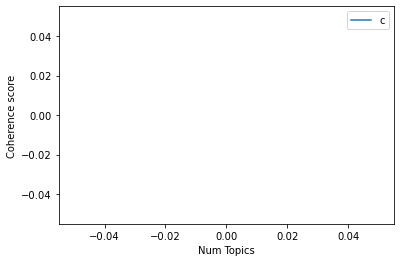

In [110]:
# Show graph
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Results - table

In [111]:
topic_df = get_lda_topics(lda_model, 10)

In [112]:
topic_df

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,year,growth,year,result,year,year,year,growth,question,premium
1,loss,month,fund,number,number,life,loss,year,covid,impact
2,underwriting,business,business,profitability,effect,calculation,business,loss,line,question
3,ratio,number,investment,eur,question,cover,growth,budget,claim,number
4,difference,year,quarter,side,bit,growth,portfolio,question,bit,business
...,...,...,...,...,...,...,...,...,...,...
95,future,riot,interest,guidance,market,eur,target,my,presentation,group
96,income,profit,comment,line,profit,lot,morbidity,theprecise,isdeposit,line
97,regard,thesetreatie,look,bond,asset,way,movement,thatchange,rate,asset
98,model,highlight,thatthere,reinsurance,longevity,accounting,population,everyelement,andnobody,gain


In [165]:
# def process_text_topic(text):
#     stemmer = PorterStemmer()
#     stopwords_english = stopwords.words('english')
#     #text = text.str
#     text = str(text)
#     text = re.sub(r'\$\w*', '', text)
#     text = re.sub(r'^RT[\s]+', '', text)
#     text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
#     text = re.sub(r'#', '', text)
#     tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
#     text_tokens = tokenizer.tokenize(text)

#     text_clean = []
#     for word in text_tokens:
#         if (word not in stopwords_english and  
#                 word not in string.punctuation): 
#             # stem_word = stemmer.stem(word)  # stemming word
#             text_clean.append(stem_word)
            
#     # sentence = ' '.join(text_clean)
    
#     return text_clean

In [167]:
# # apply the process_text_topic function to paragraph_split_df['text']
# paragraph_split_df['tokenized'] = paragraph_split_df['text'].apply(process_text_topic)
# paragraph_split_df

,text,participants,sentiment_score,meeting_date,tense,lemmatized_texts,text_tokenized,tokenized
0,"Good morning, ladies and gentlemen. I welcome ...",Operator,-0.200000,2021-11-04,past,morning lady gentleman today information confe...,"['morning', 'lady', 'gentleman', 'today', 'inf...","[good, morn, ladi, gentlemen, welcom, today', ..."
1,"Well, good morning, everyone and welcome to ou...",Jean-Jacques Henchoz,0.472222,2021-11-04,past,morning welcome conference call resultsof mont...,"['morning', 'welcome', 'conference', 'call', '...","[well, good, morn, everyon, welcom, confer, ca..."
2,"Thank you very much, Clemens. On the next slid...",Jean-Jacques Henchoz,0.520000,2021-11-04,past,slide target metric profitability target group...,"['slide', 'target', 'metric', 'profitability',...","[thank, much, clemen, next, slide, target, met..."
3,"(Question And Answer)Ladies and gentlemen, we ...",Operator,0.500000,2021-11-04,present,question answer)ladie gentleman question answe...,"['question', 'answer)ladie', 'gentleman', 'que...","[question, answer, ladi, gentlemen, begin, que..."
4,"Hi. Good morning, everyone. Could I just dig i...",Andrew Ritchie,0.500000,2021-11-04,past,morning bit catbudget man andnatcat split budg...,"['morning', 'bit', 'catbudget', 'man', 'andnat...","[hi, good, morn, everyon, could, dig, littl, b..."
...,...,...,...,...,...,...,...,...
60,Yes. Two quick questions. The first one would ...,Thomas Fossard,1.000000,2021-11-04,past,question one life longevity iguess EBIT contri...,"['question', 'one', 'life', 'longevity', 'igue...","[ye, two, quick, question, first, one, would, ..."
61,"And on the NatCat, so as Jean-Jacques explaine...",Klaus Miller,0.428571,2021-11-04,past,portfolio profitability hurdle rate pricingpoi...,"['portfolio', 'profitability', 'hurdle', 'rate...","[natcat, jean-jacqu, explain, q, investor, day..."
62,Thank you. Thank you.,Thomas Fossard,1.000000,2021-11-04,unknown,,[],"[thank, thank]"
63,And there are no further questions at this poi...,Operator,0.000000,2021-11-04,past,question point speaker remark,"['question', 'point', 'speaker', 'remark']","[question, point, hand, back, speaker, forclos..."


In [168]:
def lemmatization(texts, allowed_postags=["NOUN"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []

    for row in range(len(data_tim)):
        for text in texts:
            doc = nlp(data_tim.loc[row,"text"])
        
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

lemmatized_texts = lemmatization(data_tim)
lemmatized_texts[0]
#lemmatized_texts

def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

# print (data_words[0][0:20])


# append the data_words to the paragraph_split_df['lemmatized_texts']
paragraph_split_df['lemmatized_texts'] = lemmatized_texts
paragraph_split_df

,text,participants,sentiment_score,meeting_date,tense,lemmatized_texts,text_tokenized,tokenized
0,"Good morning, ladies and gentlemen. I welcome ...",Operator,-0.200000,2021-11-04,past,morning lady gentleman today information confe...,"['morning', 'lady', 'gentleman', 'today', 'inf...","[good, morn, ladi, gentlemen, welcom, today', ..."
1,"Well, good morning, everyone and welcome to ou...",Jean-Jacques Henchoz,0.472222,2021-11-04,past,morning welcome conference call resultsof mont...,"['morning', 'welcome', 'conference', 'call', '...","[well, good, morn, everyon, welcom, confer, ca..."
2,"Thank you very much, Clemens. On the next slid...",Jean-Jacques Henchoz,0.520000,2021-11-04,past,slide target metric profitability target group...,"['slide', 'target', 'metric', 'profitability',...","[thank, much, clemen, next, slide, target, met..."
3,"(Question And Answer)Ladies and gentlemen, we ...",Operator,0.500000,2021-11-04,present,question answer)ladie gentleman question answe...,"['question', 'answer)ladie', 'gentleman', 'que...","[question, answer, ladi, gentlemen, begin, que..."
4,"Hi. Good morning, everyone. Could I just dig i...",Andrew Ritchie,0.500000,2021-11-04,past,morning bit catbudget man andnatcat split budg...,"['morning', 'bit', 'catbudget', 'man', 'andnat...","[hi, good, morn, everyon, could, dig, littl, b..."
...,...,...,...,...,...,...,...,...
60,Yes. Two quick questions. The first one would ...,Thomas Fossard,1.000000,2021-11-04,past,question one life longevity iguess EBIT contri...,"['question', 'one', 'life', 'longevity', 'igue...","[ye, two, quick, question, first, one, would, ..."
61,"And on the NatCat, so as Jean-Jacques explaine...",Klaus Miller,0.428571,2021-11-04,past,portfolio profitability hurdle rate pricingpoi...,"['portfolio', 'profitability', 'hurdle', 'rate...","[natcat, jean-jacqu, explain, q, investor, day..."
62,Thank you. Thank you.,Thomas Fossard,1.000000,2021-11-04,unknown,,[],"[thank, thank]"
63,And there are no further questions at this poi...,Operator,0.000000,2021-11-04,past,question point speaker remark,"['question', 'point', 'speaker', 'remark']","[question, point, hand, back, speaker, forclos..."


In [170]:
# tokenize the test by row
text_tokenized = paragraph_split_df[['lemmatized_texts']].apply(lambda x: x.str.split())
text_tokenized
# make each element as string inside the list
text_tokenized = text_tokenized.apply(lambda x: [str(i) for i in x])
text_tokenized
# write back to the dataframe
paragraph_split_df['text_tokenized'] = text_tokenized
paragraph_split_df




,text,participants,sentiment_score,meeting_date,tense,lemmatized_texts,text_tokenized,tokenized
0,"Good morning, ladies and gentlemen. I welcome ...",Operator,-0.200000,2021-11-04,past,morning lady gentleman today information confe...,"['morning', 'lady', 'gentleman', 'today', 'inf...","[good, morn, ladi, gentlemen, welcom, today', ..."
1,"Well, good morning, everyone and welcome to ou...",Jean-Jacques Henchoz,0.472222,2021-11-04,past,morning welcome conference call resultsof mont...,"['morning', 'welcome', 'conference', 'call', '...","[well, good, morn, everyon, welcom, confer, ca..."
2,"Thank you very much, Clemens. On the next slid...",Jean-Jacques Henchoz,0.520000,2021-11-04,past,slide target metric profitability target group...,"['slide', 'target', 'metric', 'profitability',...","[thank, much, clemen, next, slide, target, met..."
3,"(Question And Answer)Ladies and gentlemen, we ...",Operator,0.500000,2021-11-04,present,question answer)ladie gentleman question answe...,"['question', 'answer)ladie', 'gentleman', 'que...","[question, answer, ladi, gentlemen, begin, que..."
4,"Hi. Good morning, everyone. Could I just dig i...",Andrew Ritchie,0.500000,2021-11-04,past,morning bit catbudget man andnatcat split budg...,"['morning', 'bit', 'catbudget', 'man', 'andnat...","[hi, good, morn, everyon, could, dig, littl, b..."
...,...,...,...,...,...,...,...,...
60,Yes. Two quick questions. The first one would ...,Thomas Fossard,1.000000,2021-11-04,past,question one life longevity iguess EBIT contri...,"['question', 'one', 'life', 'longevity', 'igue...","[ye, two, quick, question, first, one, would, ..."
61,"And on the NatCat, so as Jean-Jacques explaine...",Klaus Miller,0.428571,2021-11-04,past,portfolio profitability hurdle rate pricingpoi...,"['portfolio', 'profitability', 'hurdle', 'rate...","[natcat, jean-jacqu, explain, q, investor, day..."
62,Thank you. Thank you.,Thomas Fossard,1.000000,2021-11-04,unknown,,[],"[thank, thank]"
63,And there are no further questions at this poi...,Operator,0.000000,2021-11-04,past,question point speaker remark,"['question', 'point', 'speaker', 'remark']","[question, point, hand, back, speaker, forclos..."


In [124]:
try_1

'morning lady gentleman today information conference isbeing time call host today sir'

In [139]:
topic_1

0             year
1             loss
2     underwriting
3            ratio
4       difference
          ...     
95          future
96          income
97          regard
98           model
99            date
Name: Topic # 01, Length: 100, dtype: object

In [156]:
if 'year' in list(topic_1):
    print ("True")
else:
    print ("False")

True


In [164]:
try_1 = paragraph_split_df['text_tokenized'][0]
try_1

"['morning', 'lady', 'gentleman', 'today', 'information', 'conference', 'isbeing', 'time', 'call', 'host', 'today', 'sir']"

In [155]:
try_1 = paragraph_split_df['text_tokenized'][0]
topic_1 = topic_df['Topic # 01']

count = 0 
for word in try_1:
    if word in list(topic_1):
        count = count + 1
    else:
        continue
count

0

In [122]:
topic_df

# count the frequency of each word in each topic

# Create a dictonary to record the word show up in Topic # 01, so word as the key and frequency as the value
topic_01_dict = {}
for word in topic_df['Topic # 01']:
    if word in topic_01_dict:
        topic_01_dict[word] += 0
    else:
        topic_01_dict[word] = 0
topic_01_dict


{'year': 0,
 'loss': 0,
 'underwriting': 0,
 'ratio': 0,
 'difference': 0,
 'quarter': 0,
 'impact': 0,
 'assumption': 0,
 'period': 0,
 'storm': 0,
 'credit': 0,
 'stimulus': 0,
 'reporting': 0,
 'business': 0,
 'lot': 0,
 'cleanup': 0,
 'number': 0,
 'account': 0,
 'round': 0,
 'position': 0,
 'uncertainty': 0,
 'thenet': 0,
 'activity': 0,
 'figure': 0,
 'net': 0,
 'tail': 0,
 'level': 0,
 'surety': 0,
 'hand': 0,
 'protection': 0,
 'thatfreeze': 0,
 'winter': 0,
 'positiverunoff': 0,
 'trade': 0,
 'andcapacity': 0,
 'recovery': 0,
 'company': 0,
 'situation': 0,
 'termlevel': 0,
 'ourtransaction': 0,
 'half': 0,
 'wenow': 0,
 'thewinter': 0,
 'construction': 0,
 'thebulk': 0,
 'ofinsolvencie': 0,
 'gap': 0,
 'excess': 0,
 'higherthan': 0,
 'thedifference': 0,
 'insolvency': 0,
 'package': 0,
 'amount': 0,
 'effect': 0,
 'bit': 0,
 'budget': 0,
 'growth': 0,
 'portfolio': 0,
 'increase': 0,
 'side': 0,
 'line': 0,
 'mortality': 0,
 'treaty': 0,
 'way': 0,
 'reinsurance': 0,
 'change

## Visualising data and topics

In [113]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.154601  0.063548       1        1  42.726918
7      0.086837  0.174964       2        1  20.342338
3     -0.122572 -0.152784       3        1   6.856707
4     -0.006964  0.117927       4        1   6.848935
5      0.097760 -0.164498       5        1   6.431672
0     -0.159410  0.113385       6        1   3.991322
8     -0.037391 -0.112114       7        1   3.609971
9     -0.155942 -0.001351       8        1   3.374121
2      0.107033 -0.050030       9        1   3.157381
1      0.036049  0.010954      10        1   2.660636, topic_info=           Term       Freq      Total Category  logprob  loglift
231        year  65.000000  65.000000  Default  30.0000  30.0000
87       growth  46.000000  46.000000  Default  29.0000  29.0000
266    question  28.000000  28.000000  Default  28.0000  28.0000
111        line  18.000000  18.000000  Default  27.0000  27.0000
28     business  29.000000  29.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
105  investment   0.532278  15.937445  Topic10  -4.5724   0.2273
59       effect   0.530055  18.980915  Topic10  -4.5765   0.0484
99     increase   0.525531  15.576697  Topic10  -4.5851   0.2375
91       health   0.525311  18.584797  Topic10  -4.5855   0.0605
266    question   0.518450  28.103185  Topic10  -4.5987  -0.3662

[537 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
536       7  0.842709      accident
12        1  0.281272       account
12        2  0.421908       account
12        3  0.140636       account
12        4  0.140636       account
...     ...       ...           ...
467       4  0.740387        yearof
563       3  0.737707      yourline
543       7  0.842680  yourquestion
469       3  0.737707  yoursolvency
481       5  0.752410      youthink

[679 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 4, 5, 6, 1, 9, 10, 3, 2])